## CSM148 Final Project: Water Potability
### Anvesha Dutta

#### Data Preprocessing

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [102]:
import warnings
warnings.filterwarnings("ignore")
# Set seeds for reproducibility
np.random.seed(100)
random_state = 100

In [103]:
data = pd.read_csv("water_potability.csv")
data.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [105]:
data.describe().style.background_gradient(cmap = "Blues")

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [106]:
round(data.isna().sum()/ len(data) * 100, 3)

ph                 14.988
Hardness            0.000
Solids              0.000
Chloramines         0.000
Sulfate            23.840
Conductivity        0.000
Organic_carbon      0.000
Trihalomethanes     4.945
Turbidity           0.000
Potability          0.000
dtype: float64

#### Dealing with missing values according to the above % and distribution of the column values

In [108]:
#Replace null values based on the group/sample mean
data['ph']=data['ph'].fillna(data.groupby(['Potability'])['ph'].transform('mean'))
data['Sulfate']=data['Sulfate'].fillna(data.groupby(['Potability'])['Sulfate'].transform('mean'))
data['Trihalomethanes']=data['Trihalomethanes'].fillna(data.groupby(['Potability'])['Trihalomethanes'].transform('mean'))

In [109]:
data.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

#### EDA

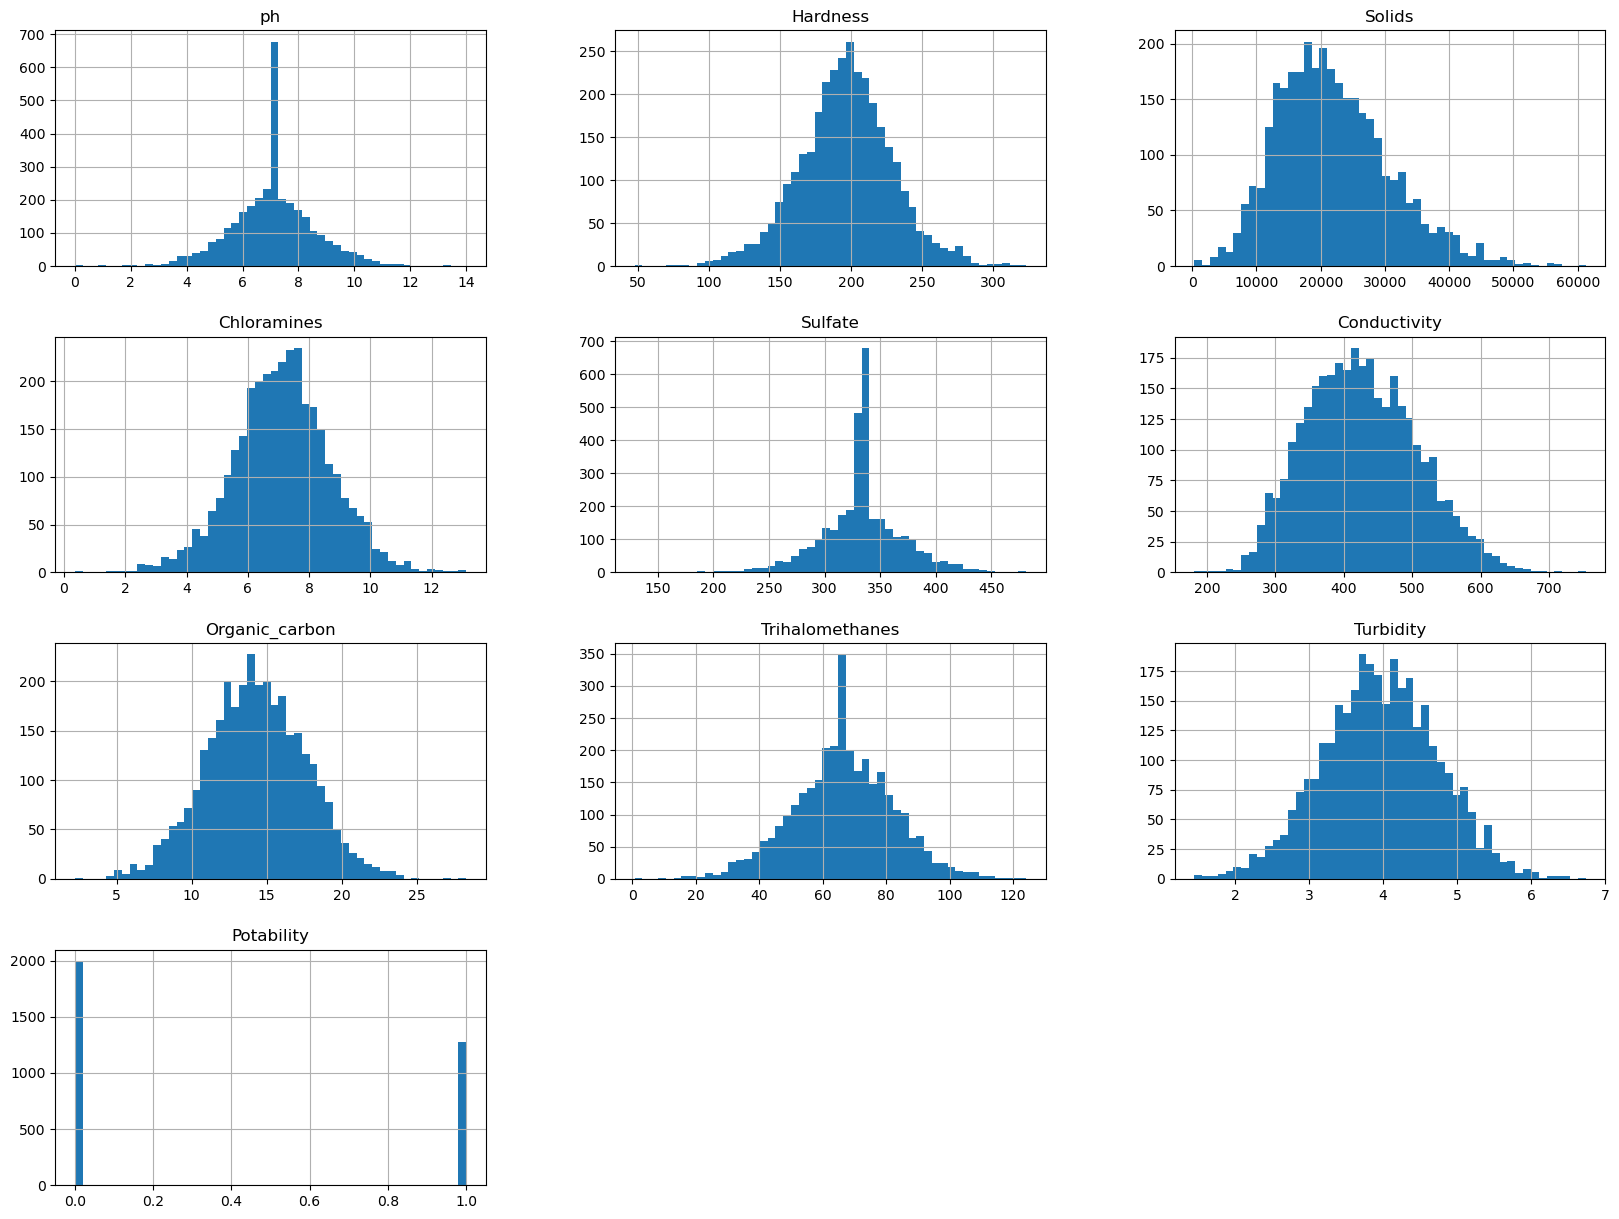

In [110]:
data.hist(bins=50, figsize=(20,15))
plt.show()

Most of the columns follow a normal distribution.

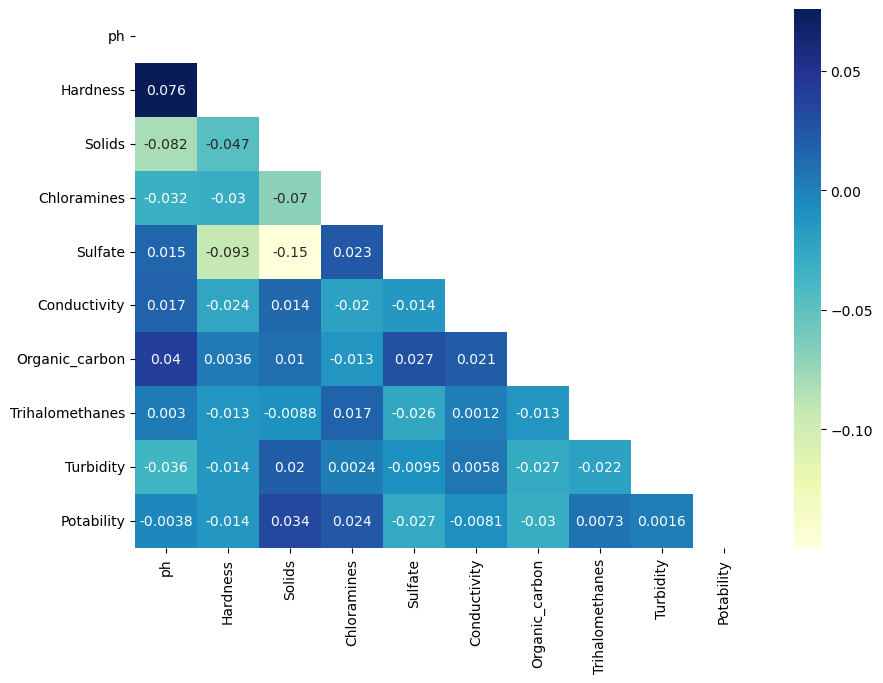

In [111]:
plt.figure(figsize=(10,7))
# creating mask
mask = np.triu(np.ones_like(data.corr()))
heatmap = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, mask=mask) 

The correlation coefficients for almost all combinations are quite low indicating that it is unlikely that we have collinearity present in the dataset.

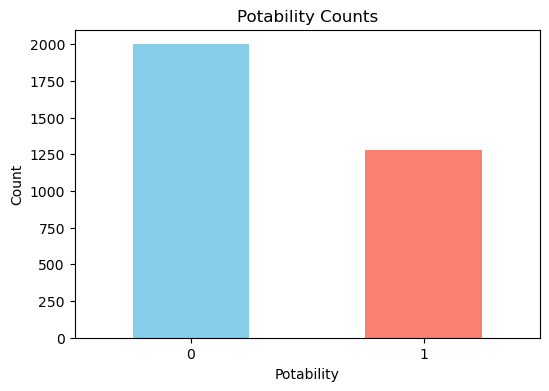

In [112]:
plt.figure(figsize=(6, 4))
data['Potability'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Potability Counts')
plt.xlabel('Potability')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [113]:
data.Potability.value_counts()

0    1998
1    1278
Name: Potability, dtype: int64

In [132]:
data.corr().abs()['Potability'].sort_values(ascending = False)

Potability         1.000000
Solids             0.033743
Organic_carbon     0.030001
Sulfate            0.026957
Chloramines        0.023779
Hardness           0.013837
Conductivity       0.008128
Trihalomethanes    0.007305
ph                 0.003848
Turbidity          0.001581
Name: Potability, dtype: float64

The dataset is imbalanced since there are many more false responses than true ones.

#### Dataset Balancing and Test/Train Split

In [114]:
target_column = 'Potability'
X = data.drop(columns=[target_column])
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Balance the training set using SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [115]:
print("Balanced Train Set:",y_train.shape, "\n", pd.DataFrame(y_train.value_counts()), "\n", "Unbalanced Test Set:", y_test.shape, "\n", pd.DataFrame(y_test.value_counts()))

Balanced Train Set: (3172,) 
    Potability
0        1586
1        1586 
 Unbalanced Test Set: (656,) 
    Potability
0         412
1         244


### Machine Learning with the models: Random Forest, Decision Trees, XGBoost

#### Feature Engineering and Normalization

In [116]:
# Feature Engineering 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [117]:
print(X_train_scaled.shape, X_test_scaled.shape)

(3172, 9) (656, 9)


#### Model Fitting and Hyperparameter Tuning

In [118]:
# Step 3: Model Training and Hyperparameter Tuning for Decision Trees
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 42],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_model = DecisionTreeClassifier(random_state=random_state)
dt_grid = GridSearchCV(dt_model, dt_params, cv=5)
dt_grid.fit(X_train_scaled, y_train)
best_dt_model = dt_grid.best_estimator_
print("The best hyperparameters for Decision Trees:\n", dt_grid.best_params_)

The best hyperparameters for Decision Trees:
 {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [119]:
# Step 4: Model Training and Hyperparameter Tuning for Random Forest
rf_params = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [2, 7, 30],
    'max_features': ['sqrt', 'log2']
}

rf_model = RandomForestClassifier(random_state=random_state)
rf_grid = GridSearchCV(rf_model, rf_params, cv=5)
rf_grid.fit(X_train_scaled, y_train)
best_rf_model = rf_grid.best_estimator_
print("The best hyperparameters for Random Forest:\n", rf_grid.best_params_)

The best hyperparameters for Random Forest:
 {'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100}


In [120]:
# Step 5: Model Training and Hyperparameter Tuning for XGBoost
xgb_params = {
    'n_estimators': [50, 100, 250],
    'learning_rate': [0.01, 0.5, 0.8],
    'max_depth': [3, 5, 7]
}

xgb_model = XGBClassifier(random_state=random_state)
xgb_grid = RandomizedSearchCV(xgb_model, xgb_params, cv=5)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb_model = xgb_grid.best_estimator_
print("The best hyperparameters for XGBoost:\n", xgb_grid.best_params_)

The best hyperparameters for XGBoost:
 {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.5}


#### Model Evaluation using evaluation metrics

In [121]:
# Step 6: Model Evaluation
def evaluate_model_with_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion_mat = confusion_matrix(y_test, y_pred)
    classification_rep = classification_report(y_test, y_pred)
    
    # Specificity
    tn, fp, fn, tp = confusion_mat.ravel()
    specificity = tn / (tn + fp)
    
    # F1 Score
    f1_score = 2 * (tp / (2 * tp + fp + fn))
    
    # ROC Curve
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    
    # Cross-validated Misclassification Rate
    cv_misclassification_rate = 1 - cross_val_score(model, X, y, cv=5, scoring="accuracy").mean()
    
    return {
        'Accuracy': accuracy.round(4),
        'Confusion Matrix': confusion_mat,
        'Specificity': specificity,
        'F1 Score': f1_score,
        'ROC AUC': roc_auc,
        'Cross-validated Misclassification Rate': cv_misclassification_rate,
        'Classification Report': classification_rep
    }


In [122]:
# Evaluate Decision Tree
dt_metrics = evaluate_model_with_metrics(best_dt_model, X_test_scaled, y_test)
print("Decision Tree Metrics:")
for metric, value in dt_metrics.items():
    print(f"{metric}: {value}")

Decision Tree Metrics:
Accuracy: 0.7149
Confusion Matrix: [[293 119]
 [ 68 176]]
Specificity: 0.7111650485436893
F1 Score: 0.6530612244897959
ROC AUC: 0.7319851185739296
Cross-validated Misclassification Rate: 0.2832712716440141
Classification Report:               precision    recall  f1-score   support

           0       0.81      0.71      0.76       412
           1       0.60      0.72      0.65       244

    accuracy                           0.71       656
   macro avg       0.70      0.72      0.71       656
weighted avg       0.73      0.71      0.72       656



In [123]:
# Evaluate Random Forest
rf_metrics = evaluate_model_with_metrics(best_rf_model, X_test_scaled, y_test)
print("\nRandom Forest Metrics:")
for metric, value in rf_metrics.items():
    print(f"{metric}: {value}")



Random Forest Metrics:
Accuracy: 0.7866
Confusion Matrix: [[327  85]
 [ 55 189]]
Specificity: 0.7936893203883495
F1 Score: 0.7297297297297297
ROC AUC: 0.8771188126691072
Cross-validated Misclassification Rate: 0.2283187488363433
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.79      0.82       412
           1       0.69      0.77      0.73       244

    accuracy                           0.79       656
   macro avg       0.77      0.78      0.78       656
weighted avg       0.79      0.79      0.79       656



In [124]:
# Evaluate XGBoost
xgb_metrics = evaluate_model_with_metrics(best_xgb_model, X_test_scaled, y_test)
print("\nXGBoost Metrics:")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value}")


XGBoost Metrics:
Accuracy: 0.7683
Confusion Matrix: [[320  92]
 [ 60 184]]
Specificity: 0.7766990291262136
F1 Score: 0.7076923076923077
ROC AUC: 0.8603672608626451
Cross-validated Misclassification Rate: 0.24358033885682362
Classification Report:               precision    recall  f1-score   support

           0       0.84      0.78      0.81       412
           1       0.67      0.75      0.71       244

    accuracy                           0.77       656
   macro avg       0.75      0.77      0.76       656
weighted avg       0.78      0.77      0.77       656



#### Trying out ensemble methods of Gradient Boosting and Bagging Classifier

In [125]:
# Model Training and Hyperparameter Tuning for Gradient Boosting
gbc_params = {
    "n_estimators": [50, 100, 200, 500],  # Number of trees
    "learning_rate": [0.01, 0.1, 0.5],  # Learning rate
    "max_depth": [3, 5, 8],  # Maximum depth of trees
    "min_samples_split": [2, 5, 10],  # Minimum samples per split
    "loss": ["deviance", "exponential"],  # Loss function for classification
}

gbc_model = GradientBoostingClassifier(random_state=random_state)  # Initialize model
gbc_grid = RandomizedSearchCV(gbc_model, gbc_params, cv=5)  # Grid search with 5-fold CV
gbc_grid.fit(X_train_scaled, y_train)  # Train model on training data
best_gbc_model = gbc_grid.best_estimator_  # Extract best model

print("Best hyperparameters for Gradient Boosting:", gbc_grid.best_params_)
print("Best model score:", gbc_grid.best_score_)

Best hyperparameters for Gradient Boosting: {'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 8, 'loss': 'exponential', 'learning_rate': 0.5}
Best model score: 0.7872003775553292


In [126]:
# Model Training and Hyperparameter Tuning for Bagging Classifier 
bagging_params = {
    "n_estimators": [50, 100, 200],  # Number of models in ensemble
    "max_samples": [0.5, 0.8, 1.0],  # Proportion of samples drawn with replacement
    "max_features": [0.5, "sqrt", "log2"],  # Number of features considered for splitting
}

bagging_model = BaggingClassifier(random_state=random_state)  # Initialize model
bagging_grid = RandomizedSearchCV(bagging_model, bagging_params, cv=5)  # Grid search with 5-fold CV
bagging_grid.fit(X_train_scaled, y_train)  # Train model on training data
best_bagging_model = bagging_grid.best_estimator_  # Extract best model
print("Best hyperparameters for Bagging:", bagging_grid.best_params_)
print("Best model score:", bagging_grid.best_score_)


Best hyperparameters for Bagging: {'n_estimators': 200, 'max_samples': 0.8, 'max_features': 0.5}
Best model score: 0.7739620954320772


In [127]:
# Evaluate Gradient Boosting Classifier
gbc_metrics = evaluate_model_with_metrics(best_gbc_model, X_test_scaled, y_test)
print("\nGradient Boosting Classifier Metrics:")
for metric, value in gbc_metrics.items():
    print(f"{metric}: {value}")


Gradient Boosting Classifier Metrics:
Accuracy: 0.7759
Confusion Matrix: [[326  86]
 [ 61 183]]
Specificity: 0.7912621359223301
F1 Score: 0.7134502923976608
ROC AUC: 0.8670619130988382
Cross-validated Misclassification Rate: 0.23869623906162718
Classification Report:               precision    recall  f1-score   support

           0       0.84      0.79      0.82       412
           1       0.68      0.75      0.71       244

    accuracy                           0.78       656
   macro avg       0.76      0.77      0.76       656
weighted avg       0.78      0.78      0.78       656



In [128]:
# Evaluate Bagging Classifier
bagging_metrics = evaluate_model_with_metrics(best_bagging_model, X_test_scaled, y_test)
print("\nBagging Classifier Metrics:")
for metric, value in bagging_metrics.items():
    print(f"{metric}: {value}")


Bagging Classifier Metrics:
Accuracy: 0.7637
Confusion Matrix: [[324  88]
 [ 67 177]]
Specificity: 0.7864077669902912
F1 Score: 0.6954813359528488
ROC AUC: 0.8555676030558651
Cross-validated Misclassification Rate: 0.2448100912306833
Classification Report:               precision    recall  f1-score   support

           0       0.83      0.79      0.81       412
           1       0.67      0.73      0.70       244

    accuracy                           0.76       656
   macro avg       0.75      0.76      0.75       656
weighted avg       0.77      0.76      0.77       656



#### Model Selection

In [129]:
# Model Selection based on Accuracy
best_model = max([(dt_metrics['Accuracy'], 'Decision Tree'),
(rf_metrics['Accuracy'], 'Random Forest'),
(xgb_metrics['Accuracy'], 'XGBoost'),
(gbc_metrics['Accuracy'], 'Gradient Boosting Classifier'),
(bagging_metrics['Accuracy'], 'Bagging Classifier')])

print(f"\nBest Model: {best_model[1]} with accuracy {best_model[0]:.4f}")


Best Model: Random Forest with accuracy 0.7866


#### Plotting the Confusion Matrix and the ROC Curve for all the models

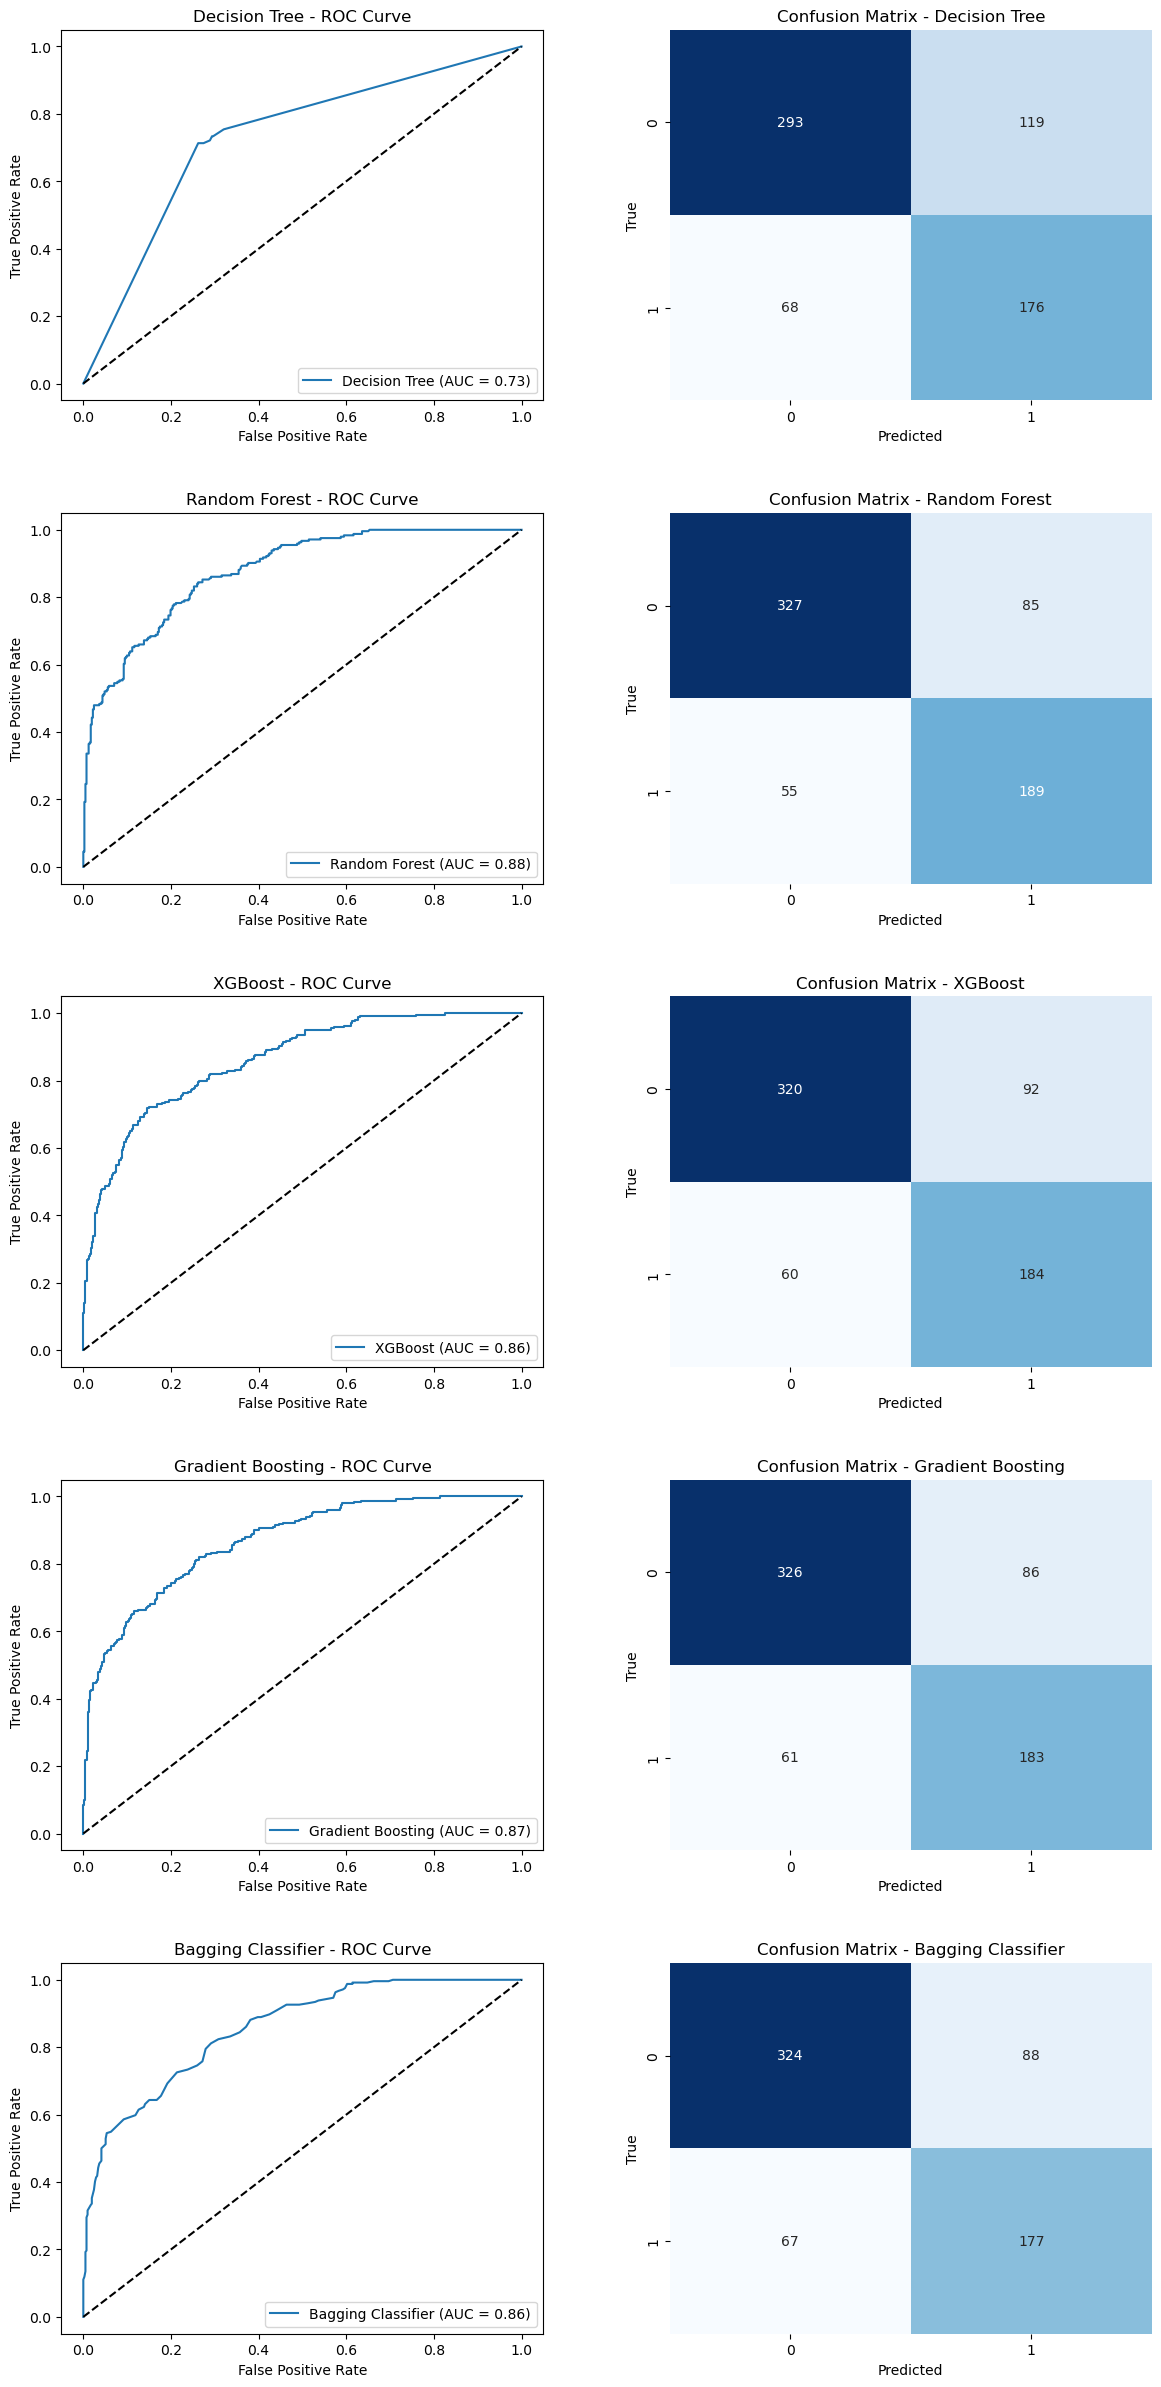

In [137]:
# Define a list of models and their names
models = [
    ('Decision Tree', best_dt_model),
    ('Random Forest', best_rf_model),
    ('XGBoost', best_xgb_model),
    ('Gradient Boosting', best_gbc_model),
    ('Bagging Classifier', best_bagging_model)
]

# Initialize a subplot
fig, axes = plt.subplots(5, 2, figsize=(13, 25))
fig.tight_layout(pad=6.0)

for i, (model_name, model) in enumerate(models):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)

    axes[i, 0].plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    axes[i, 0].plot([0, 1], [0, 1], 'k--')  # Random guess line
    axes[i, 0].set_xlabel('False Positive Rate')
    axes[i, 0].set_ylabel('True Positive Rate')
    axes[i, 0].set_title(f'{model_name} - ROC Curve')
    axes[i, 0].legend(loc='lower right')

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, model.predict(X_test_scaled))
    annot_kws = {"size": 10}
    if conf_matrix.shape == (2, 2):  # binary classification problem
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws=annot_kws, ax=axes[i, 1])
        axes[i, 1].set_title(f'Confusion Matrix - {model_name}')
        axes[i, 1].set_xlabel('Predicted')
        axes[i, 1].set_ylabel('True')
    else:
        axes[i, 1].text(0.5, 0.5, f"Invalid or empty confusion matrix for {model_name}. Unable to plot.", ha='center', va='center')

plt.show()


Feature Importance according to the random forest model

In [138]:
feature_importances=best_rf_model.feature_importances_
feature_importances_df=pd.DataFrame({'features':list(X_train), 'feature_importances':feature_importances})
feature_importances_df.sort_values('feature_importances',ascending=False)

,features,feature_importances
4,Sulfate,0.262558
0,ph,0.203861
2,Solids,0.094110
1,Hardness,0.086631
3,Chloramines,0.081178
6,Organic_carbon,0.071162
7,Trihalomethanes,0.069212
8,Turbidity,0.066372
5,Conductivity,0.064916


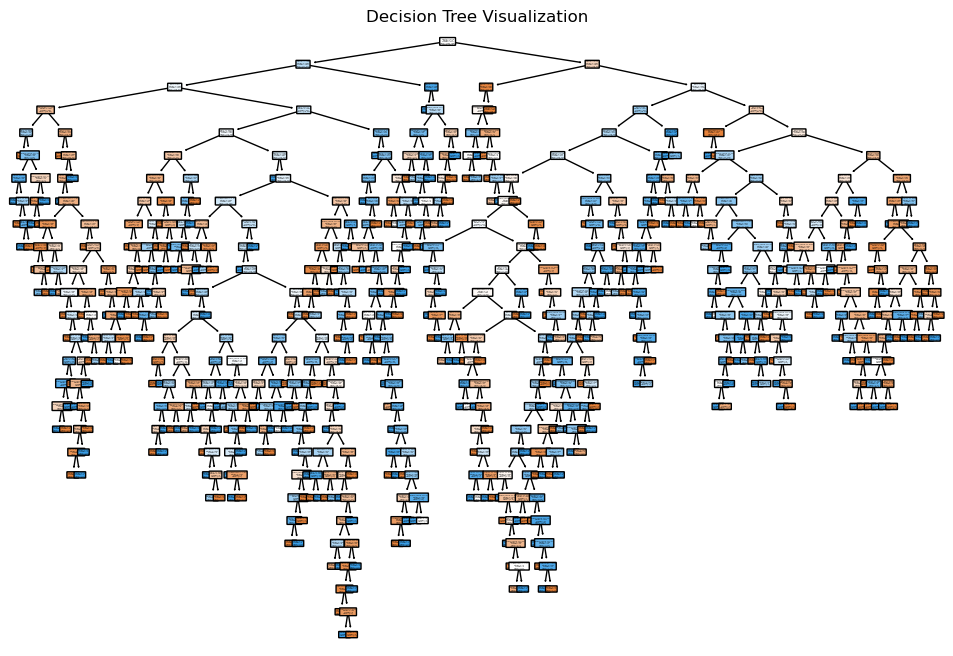

In [141]:
from sklearn.tree import plot_tree

# best_dt_model is your trained Decision Tree model
plt.figure(figsize=(12, 8))
plot_tree(best_dt_model, filled=True, feature_names=list(X_train.columns), class_names=['Class 0', 'Class 1'], rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


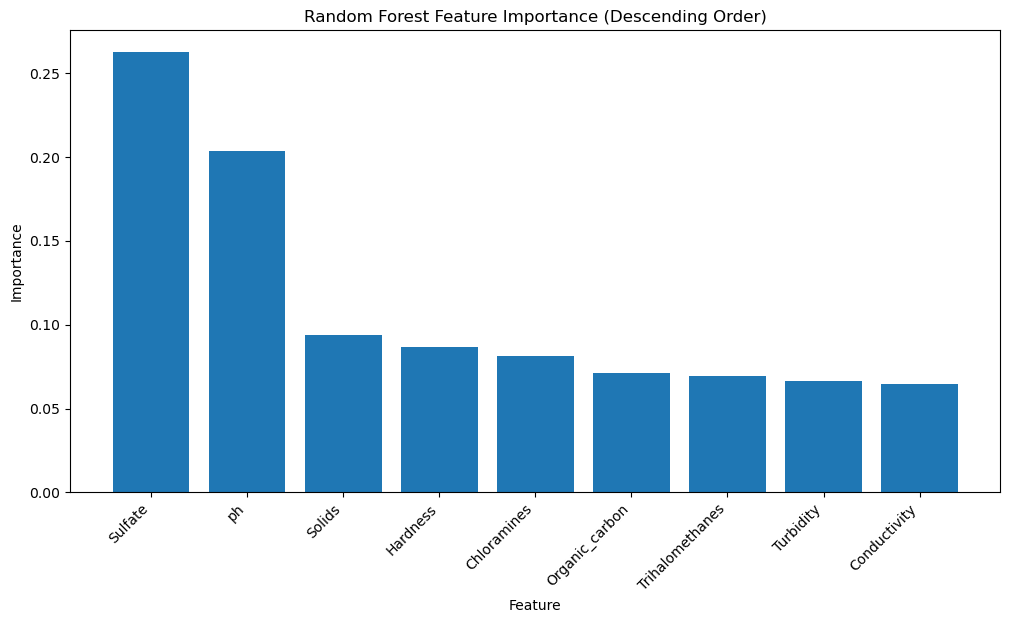

In [145]:
# Assuming best_rf_model is your trained Random Forest model
feature_importances = best_rf_model.feature_importances_

# Get indices that would sort feature importances in descending order
sorted_indices = np.argsort(feature_importances)[::-1]

# Sort feature importances and corresponding feature names
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = X_train.columns[sorted_indices]

# Create a bar plot of feature importances in descending order
plt.figure(figsize=(12, 6))
plt.bar(sorted_feature_names, sorted_feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random Forest Feature Importance (Descending Order)')
plt.xticks(rotation=45, ha='right')
plt.show()

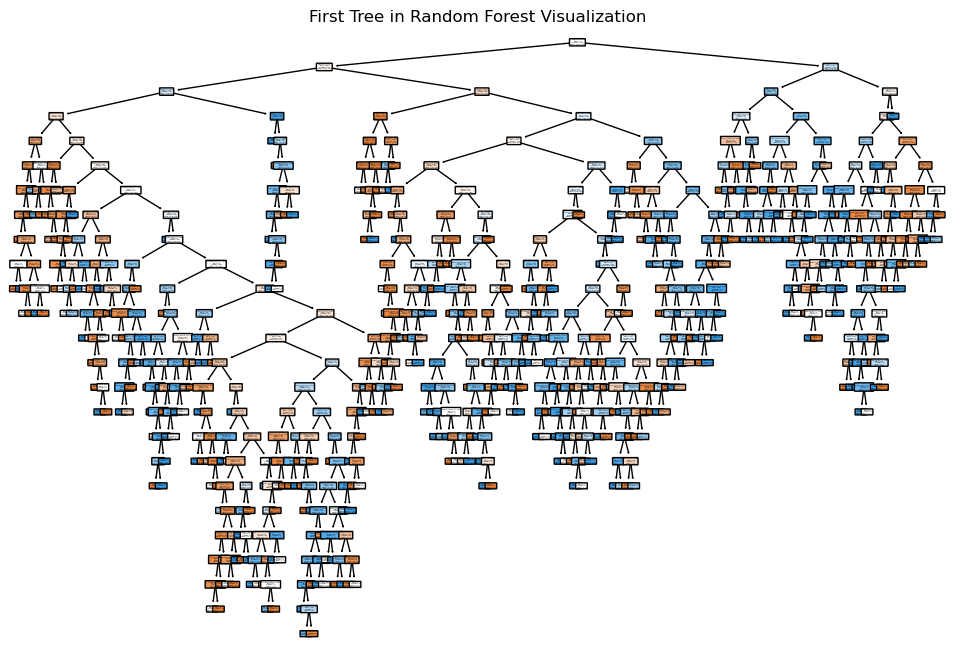

In [144]:
# Assuming best_rf_model is your trained Random Forest model
first_tree = best_rf_model.estimators_[0]

plt.figure(figsize=(12, 8))
plot_tree(first_tree, filled=True, feature_names=list(X_train.columns), class_names=['Class 0', 'Class 1'], rounded=True)
plt.title('First Tree in Random Forest Visualization')
plt.show()
